<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/006_TensorFlow_Proj_Six_FFNN_EmployeeDoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Preprocess

In [ ]:
# libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, pprint
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras

In [ ]:
print("tensorflow:", tf.__version__)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)

tensorflow: 2.13.0
pandas: 1.5.3
numpy: 1.23.5


In [ ]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
drive.mount('/content/drive')

NameError: ignored

In [ ]:
def reduce_memory_usage(df, category = False):
    start_mem = df.memory_usage().sum() / (1024**2)
    print("Memory usage of dataframe is {:2f} MB!".format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            if category:
                df[col] = df[col].astype("category")
    end_mem = df.memory_usage().sum() / (1024**2)
    print("Memory usage after optimization is {:2f} MB!".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem-end_mem) / start_mem))

In [ ]:
def display_df(df, message = " "):
    print("Dataframe: {}".format(message))
    num_rows = len(df)
    num_cols = len(df.columns)
    print("num_rows = {:,} \nnum_cols = {:,}".format(num_rows, num_cols))
    display(df.head())
    print("Info:")
    print(df.info())
    df_null = df.isnull().sum()
    if len(df_null)==0:
        print("Number of null data points:",df_null[df_null!=0])
    else:
        print("Number of null data points:")
        print(df_null[df_null!=0])

In [ ]:
def summarize_columns(df):
    num_rows = len(df)
    summary = pd.DataFrame(df.dtypes, columns=["dtypes"])
    summary = summary.reset_index()
    summary["col_name"] = summary["index"]
    summary = summary[["col_name", "dtypes"]]
    summary["missing"] = df.isnull().sum().values
    summary["missing_percent"] = summary["missing"].apply(lambda x: round(x*1000/num_rows, 1))
    summary["uniques"] = df.nunique().values
    summary["first_value"] = df.iloc[0].values
    summary["second_value"] = df.iloc[1].values
    summary["third_value"] = df.iloc[2].values
    return summary

In [ ]:
os.getcwd()

'/content'

In [ ]:
working_dir = '/content/drive/MyDrive'
os.listdir(working_dir)

['karte meli b.jpg',
 'Lottery',
 'Colab Notebooks',
 'dogs-vs-cats',
 'animals',
 'LaEterna',
 'walmart',
 'amazon',
 'arff_files',
 'forest_fires',
 'secom',
 'handwritten_text',
 'employee.csv']

In [ ]:
os.chdir(working_dir)
assert os.getcwd() == working_dir

In [ ]:
dataset = pd.read_csv("employee.csv")

In [ ]:
display_df(dataset, message = "dataset")

Dataframe: dataset
num_rows = 14,999 
num_cols = 10


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary,left
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1
3,0.72,0.87,5,223,5,0,0,sales,low,1
4,0.37,0.52,2,159,3,0,0,sales,low,1


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   promotion_last_5years  14999 non-null  int64  
 7   department             14999 non-null  object 
 8   salary                 14999 non-null  object 
 9   left                   14999 non-null  int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
None
Number of null data points:
Series([], dtype: int64)


In [ ]:
reduce_memory_usage(dataset, category = True)

Memory usage of dataframe is 1.144455 MB!
Memory usage after optimization is 0.186564 MB!
Decreased by 83.7%


In [ ]:
categorical_columns = ['Work_accident','promotion_last_5years', 'department', 'salary']
dataset[categorical_columns] = dataset[categorical_columns].astype('category')

In [ ]:
summarize_columns(dataset)

,col_name,dtypes,missing,missing_percent,uniques,first_value,second_value,third_value
0,satisfaction_level,float16,0,0.0,92,0.379883,0.799805,0.109985
1,last_evaluation,float16,0,0.0,65,0.529785,0.859863,0.879883
2,number_project,int8,0,0.0,6,2,5,7
3,average_montly_hours,int16,0,0.0,215,157,262,272
4,time_spend_company,int8,0,0.0,8,3,6,4
5,Work_accident,category,0,0.0,2,0,0,0
6,promotion_last_5years,category,0,0.0,2,0,0,0
7,department,category,0,0.0,10,sales,sales,sales
8,salary,category,0,0.0,3,low,medium,medium
9,left,int8,0,0.0,2,1,1,1


In [ ]:
dataset['left'].value_counts()/len(dataset)

0    0.761917
1    0.238083
Name: left, dtype: float64

In [ ]:
df = pd.get_dummies(dataset, drop_first=True)

In [ ]:
display_df(df, message = "df")

Dataframe: df
num_rows = 14,999 
num_cols = 19


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,left,Work_accident_1,promotion_last_5years_1,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
0,0.379883,0.529785,2,157,3,1,0,0,0,0,0,0,0,0,1,0,0,1,0
1,0.799805,0.859863,5,262,6,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0.109985,0.879883,7,272,4,1,0,0,0,0,0,0,0,0,1,0,0,0,1
3,0.720215,0.870117,5,223,5,1,0,0,0,0,0,0,0,0,1,0,0,1,0
4,0.370117,0.520020,2,159,3,1,0,0,0,0,0,0,0,0,1,0,0,1,0


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   satisfaction_level       14999 non-null  float16
 1   last_evaluation          14999 non-null  float16
 2   number_project           14999 non-null  int8   
 3   average_montly_hours     14999 non-null  int16  
 4   time_spend_company       14999 non-null  int8   
 5   left                     14999 non-null  int8   
 6   Work_accident_1          14999 non-null  uint8  
 7   promotion_last_5years_1  14999 non-null  uint8  
 8   department_RandD         14999 non-null  uint8  
 9   department_accounting    14999 non-null  uint8  
 10  department_hr            14999 non-null  uint8  
 11  department_management    14999 non-null  uint8  
 12  department_marketing     14999 non-null  uint8  
 13  department_product_mng   14999 non-null  uint8  
 14  department_sales

In [ ]:
df.rename(columns=
          {
              "Work_accident_1": "work_accident",
              "promotion_last_5years_1": "promotion_last_five_years",
              "department_RandD": "department_r_and_d"
          },
          inplace=True)

In [ ]:
X = df.drop("left", axis=1, inplace=False).values
y = df["left"].values
print(X.shape, y.shape)

(14999, 18) (14999,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=500, shuffle=True, stratify=y)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Sequential Model

In [ ]:
keras.backend.clear_session()
init_model = keras.Sequential(
    layers = [
      keras.layers.Input(shape=(X_train.shape[1],), name= "input_layer"),
      keras.layers.Dense(units=20, activation="relu", name= "dense_layer_one"),
      keras.layers.Dense(units=10, activation="relu", name= "dense_layer_two"),
      keras.layers.Dense(units=1, activation="sigmoid", name= "output_layer")
      ],
    name="init_model"
)
init_model.build(input_shape=(None, X_train.shape[1]))
init_model.summary()

Model: "init_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_layer_one (Dense)     (None, 20)                380       
                                                                 
 dense_layer_two (Dense)     (None, 10)                210       
                                                                 
 output_layer (Dense)        (None, 1)                 11        
                                                                 
Total params: 601 (2.35 KB)
Trainable params: 601 (2.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
init_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = init_model.fit(x=X_train, y=y_train, validation_split=0.2, epochs=200, batch_size=128, callbacks=[callback])

Epoch 1/200
75/75 [==============================] - 6s 10ms/step - loss: 0.5784 - accuracy: 0.7261 - val_loss: 0.5064 - val_accuracy: 0.7850
Epoch 2/200
75/75 [==============================] - 0s 6ms/step - loss: 0.4407 - accuracy: 0.8072 - val_loss: 0.4226 - val_accuracy: 0.7883
Epoch 3/200
75/75 [==============================] - 0s 5ms/step - loss: 0.3657 - accuracy: 0.8285 - val_loss: 0.3530 - val_accuracy: 0.8350
Epoch 4/200
75/75 [==============================] - 0s 4ms/step - loss: 0.3056 - accuracy: 0.8665 - val_loss: 0.2949 - val_accuracy: 0.8879
Epoch 5/200
75/75 [==============================] - 0s 4ms/step - loss: 0.2560 - accuracy: 0.9101 - val_loss: 0.2492 - val_accuracy: 0.9308
Epoch 6/200
75/75 [==============================] - 0s 5ms/step - loss: 0.2210 - accuracy: 0.9317 - val_loss: 0.2220 - val_accuracy: 0.9425
Epoch 7/200
75/75 [==============================] - 0s 5ms/step - loss: 0.1999 - accuracy: 0.9381 - val_loss: 0.2067 - val_accuracy: 0.9483
Epoch 8/200


In [ ]:
init_model.evaluate(X_test, y_test)

94/94 [==============================] - 0s 3ms/step - loss: 0.1380 - accuracy: 0.9647


[0.13798226416110992, 0.9646666646003723]

In [ ]:
model_preformance = pd.DataFrame(history.history)
model_preformance.tail()

,loss,accuracy,val_loss,val_accuracy
138,0.084624,0.973747,0.151058,0.962083
139,0.084232,0.973747,0.151363,0.961250
140,0.084486,0.974268,0.150694,0.961250
141,0.084233,0.973539,0.150329,0.962917
142,0.084239,0.972914,0.151692,0.960833


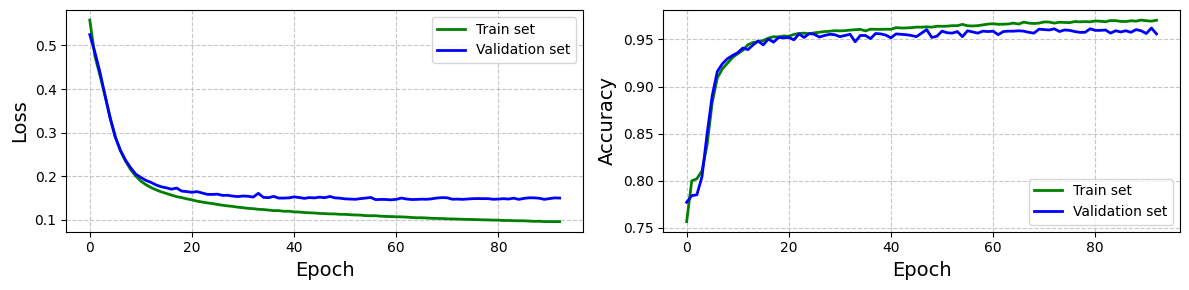

In [ ]:
plt.figure(figsize=(12, 3))
ax_one = plt.subplot(1, 2, 1)
plt.plot(model_preformance["loss"], label= "Train set", color='g', linewidth=2)
plt.plot(model_preformance["val_loss"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
# ax_one.set_facecolor('#f5f5f5')
plt.tight_layout()
ax_two = plt.subplot(1, 2, 2)
plt.plot(model_preformance["accuracy"], label= "Train set", color='g', linewidth=2)
plt.plot(model_preformance["val_accuracy"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
# ax_two.set_facecolor('#f5f5f5')
plt.tight_layout()

### Sequential Model

In [ ]:
keras.backend.clear_session()
seq_model = keras.Sequential(name="seq_model")
seq_model.add(keras.layers.Input(shape=(X_train.shape[1],)))
seq_model.add(keras.layers.Dense(units=10, activation="relu", name="first_layer"))
seq_model.add(keras.layers.Dense(units=30, activation="relu", name="second_layer"))
seq_model.add(keras.layers.Dense(units=20, activation="relu", name="third_layer"))
seq_model.add(keras.layers.Dense(units=1, activation="sigmoid", name="output_layer"))
seq_model.build(input_shape=(None, X_train.shape[1]))
seq_model.summary()

Model: "seq_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_layer (Dense)         (None, 10)                190       
                                                                 
 second_layer (Dense)        (None, 30)                330       
                                                                 
 third_layer (Dense)         (None, 20)                620       
                                                                 
 output_layer (Dense)        (None, 1)                 21        
                                                                 
Total params: 1161 (4.54 KB)
Trainable params: 1161 (4.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
seq_model.compile(optimizer="rmsprop", loss="binary_crossentropy",
                  metrics=[
                      tf.keras.metrics.Precision(),
                      keras.metrics.AUC(),
                      "accuracy",
                      "binary_crossentropy"
                  ])

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = seq_model.fit(x=X_train, y=y_train, validation_split=0.2, epochs=200, batch_size=128, callbacks=[callback])

Epoch 1/200
75/75 [==============================] - 5s 10ms/step - loss: 0.5581 - precision: 0.4288 - auc: 0.5923 - accuracy: 0.7565 - binary_crossentropy: 0.5581 - val_loss: 0.5248 - val_precision: 0.8182 - val_auc: 0.6621 - val_accuracy: 0.7771 - val_binary_crossentropy: 0.5248
Epoch 2/200
75/75 [==============================] - 0s 6ms/step - loss: 0.4758 - precision: 0.7996 - auc: 0.7273 - accuracy: 0.7999 - binary_crossentropy: 0.4758 - val_loss: 0.4845 - val_precision: 0.7500 - val_auc: 0.7507 - val_accuracy: 0.7842 - val_binary_crossentropy: 0.4845
Epoch 3/200
75/75 [==============================] - 0s 6ms/step - loss: 0.4310 - precision: 0.7403 - auc: 0.8056 - accuracy: 0.8021 - binary_crossentropy: 0.4310 - val_loss: 0.4383 - val_precision: 0.6990 - val_auc: 0.8235 - val_accuracy: 0.7850 - val_binary_crossentropy: 0.4383
Epoch 4/200
75/75 [==============================] - 0s 6ms/step - loss: 0.3847 - precision: 0.7388 - auc: 0.8653 - accuracy: 0.8104 - binary_crossentropy: 

In [ ]:
seq_model.evaluate(X_test, y_test)

94/94 [==============================] - 1s 8ms/step - loss: 0.1336 - precision: 0.9092 - auc: 0.9784 - accuracy: 0.9573 - binary_crossentropy: 0.1336


[0.13362446427345276,
 0.909217894077301,
 0.9784475564956665,
 0.9573333263397217,
 0.13362446427345276]

In [ ]:
model_preformance = pd.DataFrame(history.history)
model_preformance.tail()

,loss,precision,auc,accuracy,binary_crossentropy,val_loss,val_precision,val_auc,val_accuracy,val_binary_crossentropy
88,0.097087,0.949246,0.988601,0.969372,0.097087,0.149847,0.935875,0.971716,0.960417,0.149847
89,0.096135,0.951554,0.988966,0.970518,0.096135,0.147225,0.929553,0.972727,0.959167,0.147225
90,0.096279,0.950985,0.988850,0.969788,0.096279,0.148894,0.911519,0.974619,0.956250,0.148894
91,0.096137,0.949657,0.988673,0.969372,0.096137,0.150560,0.948673,0.968898,0.962083,0.150560
92,0.096151,0.951510,0.988635,0.970309,0.096151,0.150196,0.912752,0.973929,0.955833,0.150196


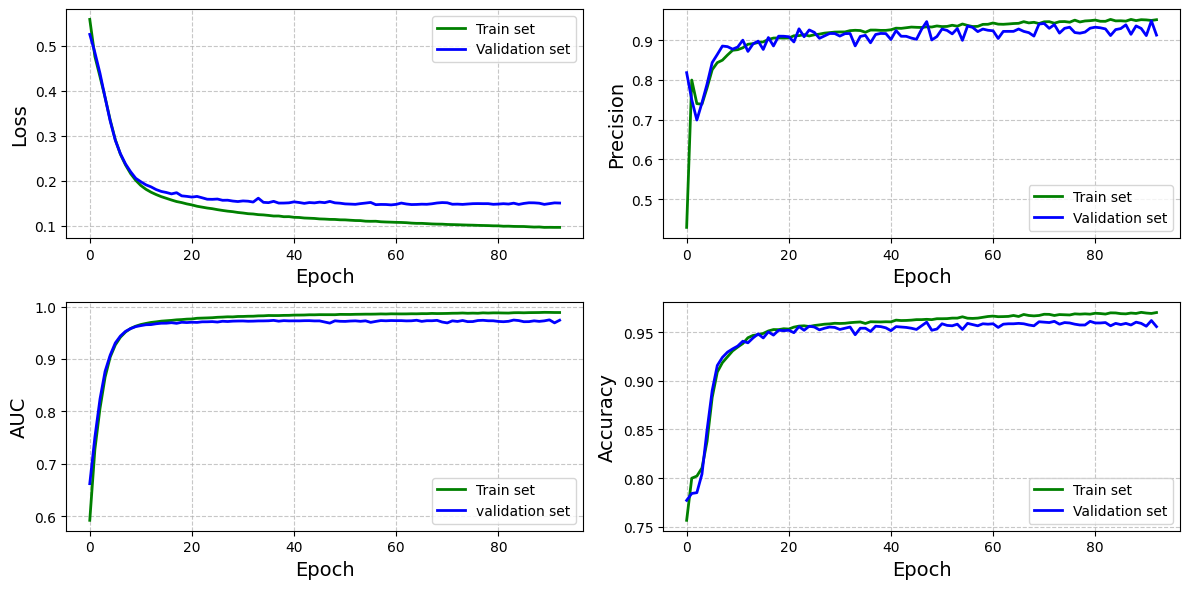

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(model_preformance["loss"], label= "Train set", color='g', linewidth=2)
plt.plot(model_preformance["val_loss"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.subplot(2, 2, 2)
plt.plot(model_preformance["precision"], label= "Train set", color='g', linewidth=2)
plt.plot(model_preformance["val_precision"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Precision", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.subplot(2, 2, 3)
plt.plot(model_preformance["auc"], label= "Train set", color='g', linewidth=2)
plt.plot(model_preformance["val_auc"], label= "validation set", color='b', linewidth=2)
plt.ylabel("AUC", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.subplot(2, 2, 4)
plt.plot(model_preformance["accuracy"], label= "Train set", color='g', linewidth=2)
plt.plot(model_preformance["val_accuracy"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

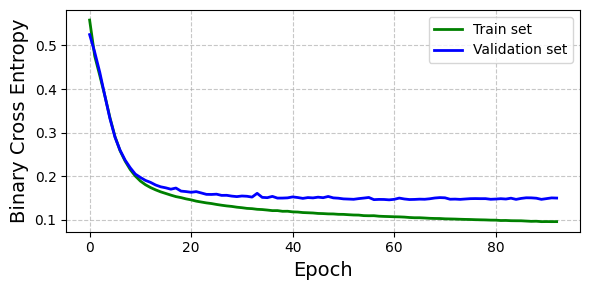

In [ ]:
plt.figure(figsize=(6, 3))
plt.plot(model_preformance["binary_crossentropy"], label= "Train set", color='g', linewidth=2)
plt.plot(model_preformance["val_binary_crossentropy"], label= "Validation set", color='b', linewidth=2)
plt.ylabel("Binary Cross Entropy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

In [ ]:
y_pred = np.rint(seq_model.predict(X_test))

94/94 [==============================] - 0s 3ms/step


In [ ]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize=None)

In [ ]:
conf_mat
# plt.figure(figsize=(8, 6))
# sns.set(font_scale=1.2)
# sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=.5, cmap='Blues_r', cbar=False, square=True,
#             xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
# plt.xlabel('Predicted', fontsize=14)
# plt.ylabel('Actual', fontsize=14)
# plt.show()

array([[2221,   65],
       [  63,  651]])

### Functional API

In [ ]:
keras.backend.clear_session()
inputs = keras.Input(shape=(X_train.shape[1],), name="input_layer")
features = keras.layers.Dense(10, activation="relu", name="first_layer")(inputs)
features = keras.layers.Dropout(rate=0.2, name="first_drop_out")(features)
features = keras.layers.Dense(20, activation="relu", name="second_layer")(features)
features = keras.layers.Dense(5, activation="relu", name="third_layer")(features)
features = keras.layers.Dropout(rate=0.3, name="second_drop_out")(features)
outputs = keras.layers.Dense(1, activation="sigmoid", name="output_layer")(features)
func_model = keras.Model(inputs=inputs, outputs=outputs, name="func_model")
func_model.summary()

Model: "func_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 18)]              0         
                                                                 
 first_layer (Dense)         (None, 10)                190       
                                                                 
 first_drop_out (Dropout)    (None, 10)                0         
                                                                 
 second_layer (Dense)        (None, 20)                220       
                                                                 
 third_layer (Dense)         (None, 5)                 105       
                                                                 
 second_drop_out (Dropout)   (None, 5)                 0         
                                                                 
 output_layer (Dense)        (None, 1)                 6

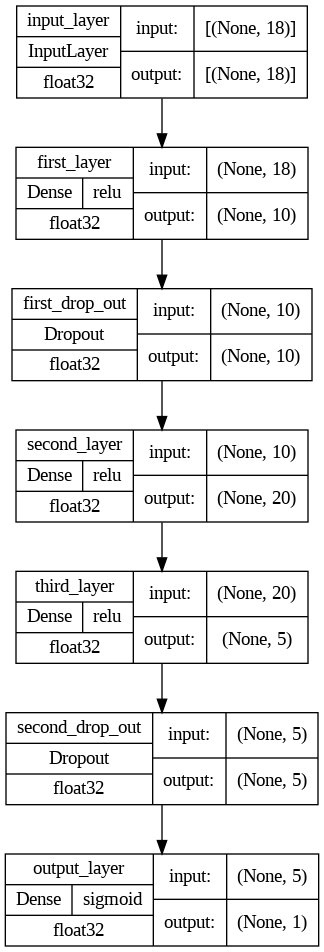

In [ ]:
keras.utils.plot_model(func_model, "clf.png", show_dtype=True, show_layer_activations=True,
                       show_layer_names=True, show_shapes=True)

In [ ]:
func_model.layers

In [ ]:
func_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
func_model.fit(X_train,y_train, validation_split=0.3, epochs=200, batch_size=128, callbacks=[early_stopping])

Epoch 1/200
66/66 [==============================] - 2s 8ms/step - loss: 0.6182 - accuracy: 0.6732 - val_loss: 0.5447 - val_accuracy: 0.7553
Epoch 2/200
66/66 [==============================] - 0s 5ms/step - loss: 0.5411 - accuracy: 0.7609 - val_loss: 0.5105 - val_accuracy: 0.7525
Epoch 3/200
66/66 [==============================] - 0s 5ms/step - loss: 0.5123 - accuracy: 0.7626 - val_loss: 0.4809 - val_accuracy: 0.7556
Epoch 4/200
66/66 [==============================] - 0s 6ms/step - loss: 0.4887 - accuracy: 0.7653 - val_loss: 0.4524 - val_accuracy: 0.7669
Epoch 5/200
66/66 [==============================] - 0s 5ms/step - loss: 0.4656 - accuracy: 0.7782 - val_loss: 0.4270 - val_accuracy: 0.7731
Epoch 6/200
66/66 [==============================] - 0s 5ms/step - loss: 0.4467 - accuracy: 0.7863 - val_loss: 0.4012 - val_accuracy: 0.7867
Epoch 7/200
66/66 [==============================] - 0s 5ms/step - loss: 0.4228 - accuracy: 0.8013 - val_loss: 0.3784 - val_accuracy: 0.8139
Epoch 8/200
6

In [ ]:
func_model.evaluate(X_test, y_test)

94/94 [==============================] - 0s 3ms/step - loss: 0.1527 - accuracy: 0.9543


[0.1526770442724228, 0.9543333053588867]

In [ ]:
y_pred = np.rint(func_model.predict(X_test))

94/94 [==============================] - 0s 3ms/step


In [ ]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true')
conf_mat

array([[0.97550306, 0.02449694],
       [0.11344538, 0.88655462]])